# Load in data

In [30]:
import os

def get_all_filepaths(directory):
  '''
  A helper function to get all absolute file paths in a directory (recursively)
  :param directory:  The directory for which we want to get all file paths
  :return         :  A list of all absolute file paths as strings
  '''
  for dirpath, _, filenames in os.walk(directory):
    for f in sorted(filenames):
      yield os.path.abspath(os.path.join(dirpath, f))

In [31]:
import cv2
import json
from PIL import Image

def load_sample_images(sample_pathnames):
  '''
  Initial loading the given images. 
  :param sample_pathnames: An array of image file paths that need to be opened
  :return:                 A dictionary of the form key:image_dictionary,
                           whereby image_dictionary itself is a dictionary 
                           containing the original image and the preprocessed
                           image for later steps
  '''
  sample_images = {}

  data = json.load(open('beerlabels.json', encoding='utf-8'))

  for filename in sample_pathnames:  # Loop through all images, load each file
    beer_id = filename.split('\\')[7].split('.')[0]
    beer_info = [x for x in data if x['untappd']['id'] == int(beer_id)][0]
    sample_images[beer_id] = {}
    sample_images[beer_id]['original'] = Image.open(filename)
    sample_images[beer_id]['cv2'] = cv2.imread(filename)
    sample_images[beer_id]['rating'] = beer_info['untappd']['beer_rating']
  return(sample_images)

In [32]:
sample_pathnames = sorted(list(get_all_filepaths('beer_labels')))
sample_images = load_sample_images(sample_pathnames)
print('We have loaded ' + str(len(sample_pathnames)) + ' images!')

We have loaded 1123 images!


In [33]:
# Get filename of the image with index 2
filename = sample_pathnames[2].split('\\')[7].split('.')[0]
print('This is our filename: {}'.format(filename))

# Get the dictionary for that image
print('This is the dictionary for this image:')
print(sample_images[filename])

# Get the image loaded using PIL:
print('The image when loaded using PIL:')
print(sample_images[filename]['original'])

# Get the image loaded using cv2:
print('The image when loaded using cv2:')
print(sample_images[filename]['cv2'])

# Get the rating of the image in Untappd
print('The rating of the image using Untappd data')
print(sample_images[filename]['rating'])

This is our filename: 1003762
This is the dictionary for this image:
{'original': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=436x472 at 0x208A5075100>, 'cv2': array([[[183, 194, 192],
        [ 79, 144, 152],
        [ 79, 141, 165],
        ...,
        [ 98, 130, 173],
        [ 81, 117, 157],
        [126, 170, 207]],

       [[177, 186, 200],
        [ 76, 143, 164],
        [ 81, 142, 182],
        ...,
        [112, 150, 192],
        [ 85, 126, 165],
        [ 67, 113, 147]],

       [[173, 184, 211],
        [ 78, 146, 181],
        [ 88, 151, 202],
        ...,
        [ 99, 144, 182],
        [121, 169, 205],
        [ 94, 147, 180]],

       ...,

       [[110, 152, 199],
        [112, 148, 194],
        [117, 147, 194],
        ...,
        [117, 185, 204],
        [105, 163, 185],
        [113, 167, 190]],

       [[ 82, 137, 180],
        [ 93, 144, 187],
        [ 98, 141, 184],
        ...,
        [129, 173, 202],
        [104, 143, 171],
        [121, 156,

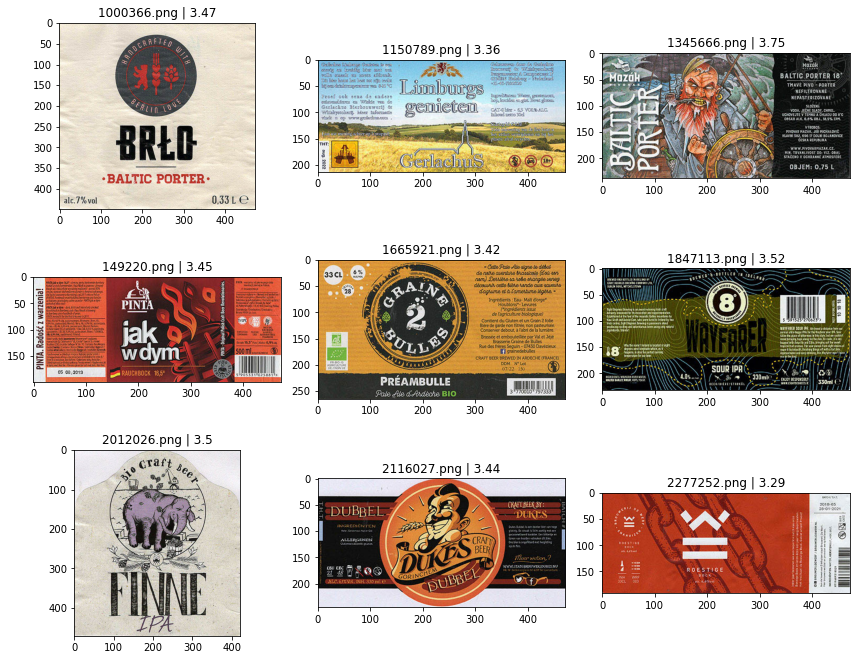

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12)) 
for i in range(0,9): 
  subplot = fig.add_subplot(4,3,i+1)
  imgplot = plt.imshow(sample_images[sample_pathnames[i*50].split('\\')[7].split('.')[0]]['original'])
  subplot.set_title(sample_pathnames[i*50].split('\\')[7] + ' | ' + str(sample_images[sample_pathnames[i*50].split('\\')[7].split('.')[0]]['rating']))

fig.tight_layout()
plt.show()

In [35]:
import time

def create_features(feature_funcs, image_dict):
  '''
  Loops over function names and calls each function and applies them on image
  :param feature_funcs:   A list of functions that extract individual features
  :param image_dict:       The loaded image dictionary to extract features from
  :return:                 The feature vector for the image
  '''
  feature_vector = []  
  for func in feature_funcs: # Subsequently apply each function
    feature_vector.extend(func(image_dict)) 
  return feature_vector  


def create_features_all_samples(feature_funcs,verbose=False):
  '''
  Loops over all sample images and calls create_features for each of them.
  :param feature_funcs:   A list of functions that extract individual features 
  :param verbose:         True if print statements of progress are desired
  :return:                All feature vectors combined in an array
  '''
  feature_vectors = []
  start = time.time()
  counter = 0 # Used to compute progress
  for sample_pathname in sample_pathnames:
    feature_vectors.append(create_features(feature_funcs, sample_images[sample_pathname.split('\\')[7].split('.')[0]]))
    counter = counter +1
    if verbose:
      if counter%25 == 0:
        print('Number of samples with features extracted: {}'.format(counter))  
        print("Time elapsed for last 25 samples: {}".format(time.time() - start))
        start = time.time()
  return feature_vectors

In [36]:
import numpy as np 

def average_color(image_dict):
  '''
  A function to compute the average RGB value of an image.
  First, average over rows to obtain an average value per column.
  Then, average over the resulting values to obtain one average value per color 
  channel.
  
  :param image_dict:  The dictionary containing the loaded image 
  :return:            A 3-dimensional np array: 1 average per color channel
  '''

  averageColorRow = np.average(image_dict['cv2'], axis=0)
  averageColorColumn = np.average(averageColorRow, axis=0)

  return np.array(averageColorColumn)

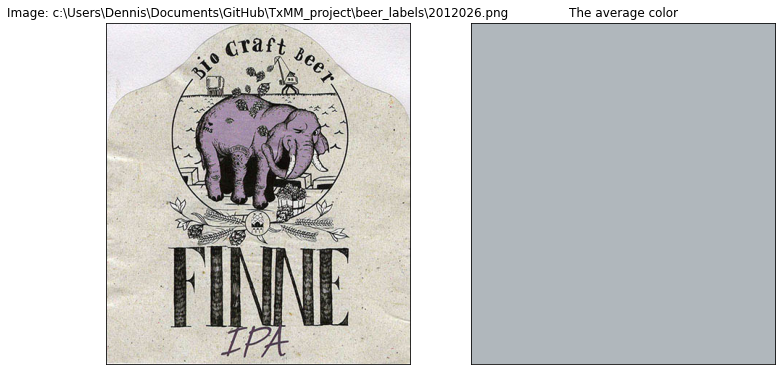

In [37]:
# Extract the average color
test_image_name = sample_pathnames[300] # Change the index here to see more examples
test_image_dict = sample_images['2012026'] 
test_image = test_image_dict['original']
avg_color = average_color(test_image_dict).astype(int) # Cast for plotting

# Plot the test image next to the average color
fig = plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(test_image)
plt.title('Image: {}'.format(test_image_name)), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(Image.new("RGB", (test_image.size[0],test_image.size[1]),\
                  (avg_color[0], avg_color[1], avg_color[2])))
plt.title('The average color'), plt.xticks([]), plt.yticks([])
fig.show()

In [38]:
avg_color_feature_vectors = np.asarray([create_features([average_color], sample_images[x.split('\\')[7].split('.')[0]]) for x in sample_pathnames])
print('The dimensions of our array: {}'.format(avg_color_feature_vectors.shape))

The dimensions of our array: (1123, 3)


In [39]:
from sklearn.cluster import KMeans

def perform_k_means_clustering(feature_vectors,n_clusters=6):
  '''
  This function performs the clustering for us! It returns the n clusters.
  :param feature_vectors: The feature vectors that represent our data samples.
  :param n_clusters:      The number of clusters we want at the end
  '''
  kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(feature_vectors)
  y_kmeans = kmeans.predict(feature_vectors)
  return y_kmeans

In [40]:
y_kmeans_avg_color = perform_k_means_clustering(avg_color_feature_vectors) 
print("This is the clustering algorithm's output: ")
print(y_kmeans_avg_color)

This is the clustering algorithm's output: 
[4 4 3 ... 1 4 0]


In [41]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

def print_interactive_3d_cluster(features, feature_names, y_kmeans,filenames):
  '''
  A function to create an interactive (i.e. turnable) 3d scatterplot from our features.
  Importantly, this can only be done successfully if we only have 3 dimensions. 
  :param features:       A 3d vector 
  :param feature_names:  d
  :param y_kmeans:       d
  '''

  if not (features.shape[1]<3 or len(feature_names)!=3): # Check if dimensions fit
    # The following lines are a hack since plotly needs a pandas df as input
    helper = pd.DataFrame()
    helper[feature_names[0]] = features[:,0]
    helper[feature_names[1]] = features[:,1]
    helper[feature_names[2]] = features[:,2]
    helper['cluster_index'] = [str(clusternum) for clusternum in y_kmeans]
    helper['filenames'] = filenames

    data = json.load(open('beerlabels.json', encoding='utf-8'))
    ratings = []
    for filename in filenames:
      beer_id = filename.split('\\')[7].split('.')[0]
      beer_info = [x for x in data if x['untappd']['id'] == int(beer_id)][0]
      ratings.append(beer_info['untappd']['beer_rating'])

    helper['rating'] = ratings

    # Create our scatter plot
    fig = px.scatter_3d(helper, x=feature_names[0], y=feature_names[1], z=feature_names[2], 
                       color = 'cluster_index', hover_data = ['filenames', 'rating'])  
    fig.show()
  else:     
    print('Sorry. This function only works for 3-dimensional feature vectors..')

In [42]:
fig = print_interactive_3d_cluster(avg_color_feature_vectors,['red_average','green_average','blue_average'], y_kmeans_avg_color,sample_pathnames)

In [43]:
total = {}
for filename in sample_images:
    total[filename] = {}
    total[filename]['rating'] = sample_images[filename]['rating']

    index = list(sample_images.keys()).index(filename)
    total[filename]['cluster_id'] = str(y_kmeans_avg_color[index])

with open('avg_color.json', 'w') as outfile:
    json.dump(total, outfile)


In [44]:
# You might have to restart your runtime after this line executes
!pip install --upgrade imutils

Requirement already up-to-date: imutils in c:\users\dennis\anaconda3\lib\site-packages (0.5.4)


In [45]:
from imutils import build_montages

def show_images_in_clusters(y_kmeans, sample_pathnames, sample_images):
  '''
  Create a montage for each cluster in y_kmeans featuring images in that cluster
  and subsequently display those montages. 
  :param y_kmeans:          The output vector of a clustering algorithm containing 
                            cluster indices for each sample
  :param sample_pathnames:  Our filenames list
  :param sample_images:     Our image dictionary 
  '''
  colnum = 9 # Specified by us, 9 columns looked the nicest.
  for cluster_index in np.unique(y_kmeans):
    montage_images = [np.asarray(sample_images[sample_pathnames[index].split('\\')[7].split('.')[0]]['original']) \
                      for index, value in enumerate(y_kmeans) if value == cluster_index]
    rownum = int(len(montage_images)/colnum) # Calculate the number of rows we'll need
    if rownum == 0: rownum =1
    montages = build_montages(montage_images, (128, 196), (colnum, rownum))[0]
    fig = plt.figure(figsize=(30, 30))
    plt.title('Cluster index: {}'.format(cluster_index)), plt.xticks([]), plt.yticks([])
    plt.imshow(montages)

In [ ]:
show_images_in_clusters(y_kmeans_avg_color, sample_pathnames, sample_images)

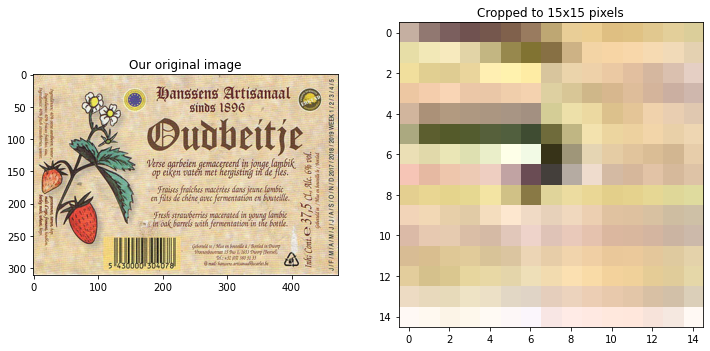

In [47]:
test_image = Image.open('./beer_labels/1959.png')
# Crop the image -> zoomed-in view on lower right pixel values
w, h = test_image.size
subpart_test_image = np.array(test_image.crop((w-15, h-15, w, h)))

# Plot the image and the cropped subpart of the image
fig = plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(test_image)
plt.title('Our original image')
plt.subplot(122), plt.imshow(subpart_test_image)
plt.title('Cropped to 15x15 pixels')
fig.show()

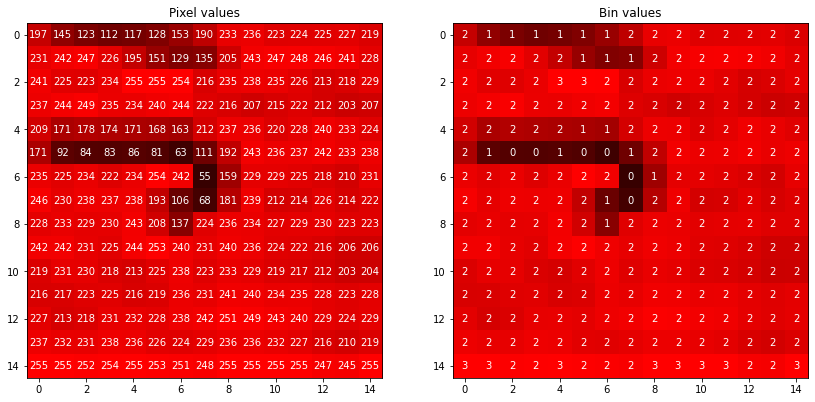

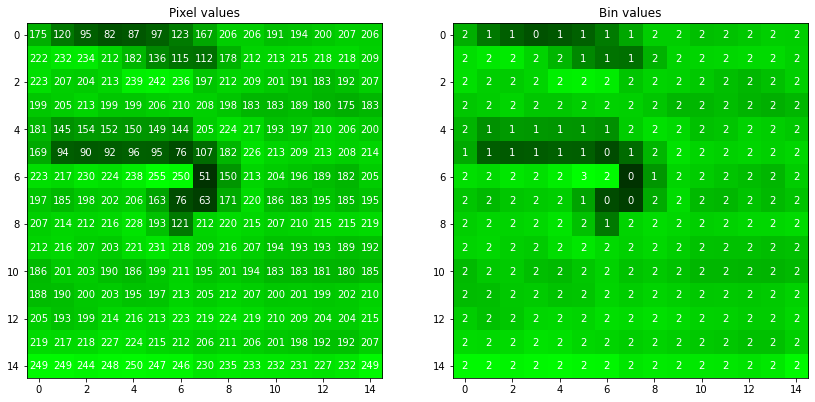

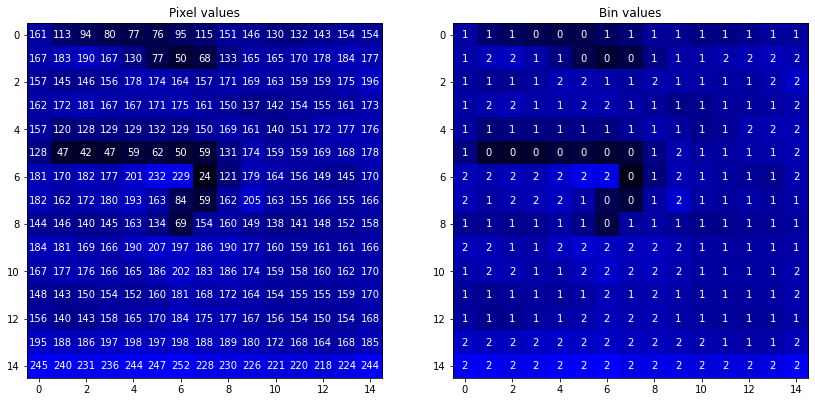

In [48]:
# Create one image for each color channel:
for i in range(3):
  channel_img = np.zeros(subpart_test_image.shape, dtype='uint8')
  channel_img[:,:,i] = subpart_test_image[:,:,i]
  # First plot the color channel with the actual pixel values
  px_values = channel_img[:,:,i]
  plt.figure(figsize=(14,14))
  ax = plt.subplot(1,2,1)
  im = ax.imshow(channel_img)
  # Put the pixel values as text on top of the image:
  for j in range(channel_img.shape[0]):
    for k in range(channel_img.shape[1]):
      text = ax.text(k, j, px_values[j, k], ha="center", va="center", color="w")
  plt.title('Pixel values')
  # Now plot the color channel with the bin values
  bin_values = np.floor_divide(px_values,255/3).astype(int)
  ax = plt.subplot(1,2,2)
  im = ax.imshow(channel_img)
  for j in range(channel_img.shape[0]):
    for k in range(channel_img.shape[1]):
      text = ax.text(k, j, bin_values[j, k], ha="center", va="center", color="w")
  plt.title('Bin values')
  

In [49]:
def color_histogram(image_dict):
  '''
  Compute the normalized color histogram binned into 27 bins from the HSV image. 
  :param image_dict:  The dictionary containing the loaded image 
  :return:            A 27-dimensional np array
  '''
  # extract a 3D color histogram from the RGB color space
  im = image_dict['cv2']
  hist = cv2.calcHist([im], [0, 1, 2], None, [3,3,3], [0, 256, 0, 256, 0, 256])
  # normalize the histogram
  hist = cv2.normalize(hist,hist)
  # return the flattened histogram as the feature vector
  return hist.flatten() 

In [50]:
test_chist_vector = color_histogram(test_image_dict)
test_chist_vector

array([1.56785324e-01, 3.33305495e-03, 0.00000000e+00, 6.78467681e-04,
       5.27623901e-03, 6.58706495e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.24577170e-04, 3.11568170e-03, 0.00000000e+00,
       1.31741297e-04, 1.15155071e-01, 4.90736356e-03, 0.00000000e+00,
       5.40139328e-04, 1.59736332e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.04207369e-02, 1.11519005e-02,
       0.00000000e+00, 1.18567172e-04, 9.80609775e-01], dtype=float32)

In [51]:
chist_feature_vectors =  create_features_all_samples([color_histogram],verbose=False)
y_kmeans_chist = perform_k_means_clustering(chist_feature_vectors)

In [ ]:
show_images_in_clusters(y_kmeans_chist, sample_pathnames, sample_images)

In [53]:
total = {}
for filename in sample_images:
    total[filename] = {}
    total[filename]['rating'] = sample_images[filename]['rating']

    index = list(sample_images.keys()).index(filename)
    total[filename]['cluster_id'] = str(y_kmeans_chist[index])

with open('chist.json', 'w') as outfile:
    json.dump(total, outfile)

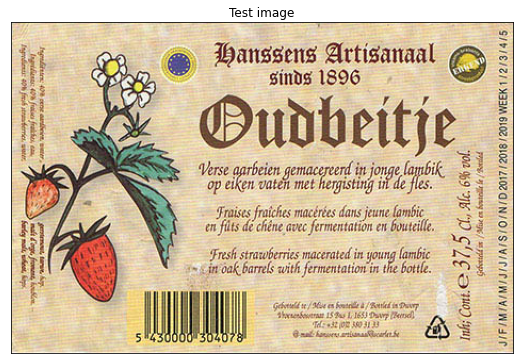

In [54]:
fig = plt.figure(figsize=(9,9))
plt.imshow(test_image) , plt.xticks([]), plt.yticks([])
plt.title('Test image')
plt.show()

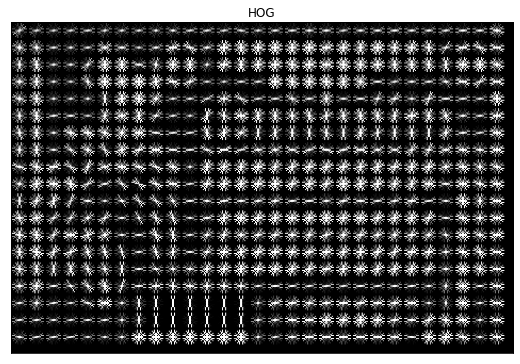

In [55]:
from skimage.feature import hog
from skimage import exposure

fd, hog_image = hog(test_image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True, feature_vector=True)
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig = plt.figure(figsize=(9,9))
plt.imshow(hog_image, cmap=plt.cm.gray) , plt.xticks([]), plt.yticks([])
plt.title('HOG')
plt.show()

In [56]:
def hog_vector(image_dict):
  '''
  Compute the histogram of oriented gradients binned into 8 bins. 
  :param image_dict:  The dictionary of loaded images for that image
  :return:            A feature vector of length 8        
  '''
  img = image_dict['original'].resize((300,300), Image.ANTIALIAS)  
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True, feature_vector=True)  
  
  return fd

In [57]:
test_hog_vector = hog_vector(test_image_dict)
test_hog_vector

array([0.3592485 , 0.3592485 , 0.3592485 , ..., 0.33522791, 0.35609434,
       0.35609434])

In [ ]:
hog_feature_vectors =  create_features_all_samples([hog_vector],verbose=False)
y_kmeans_hog = perform_k_means_clustering(hog_feature_vectors, n_clusters=6)
show_images_in_clusters(y_kmeans_hog, sample_pathnames, sample_images)

In [59]:
total = {}
for filename in sample_images:
    total[filename] = {}
    total[filename]['rating'] = sample_images[filename]['rating']

    index = list(sample_images.keys()).index(filename)
    total[filename]['cluster_id'] = str(y_kmeans_hog[index])

with open('hog.json', 'w') as outfile:
    json.dump(total, outfile)